# MPA Model Scratch Sheet

This notebook shows basic use of the MPA model as I've got it working so far.  The fish population and spillover dynamics follow the definitions in [this paper](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0107032) (Buxton et al. 2014, PLoS One).

I've written the model and this notebook in [Julia](https://julialang.org/) because 1) I like it and 2) it is much faster than R or Python. The model as written so far is not computationally demanding, but if we want to run a bajillion replicated simulations, it will be much easier this way 😉.  Loading the required packages:

In [2]:
using Plots
using Optim
using Polynomials

include("mpa_model.jl")
m = MpaModel

Main.MpaModel

I have changed the catch function from that in Buxton et al.  My fishing boats follow a Type-II functional response, i.e. a higher density of fish leads to a higher catch rate until their handling time causes the function to saturate.  

How the fishers adjust their preferred MPA size (as a fraction $\alpha$ of the total fishing ground) is a bit of a work in progress.  Right now, I have them adjusting it up or down depending on whether they caught more fish at time $t$ than they did at time $t-1$ according to the formula 

$$\alpha_t = \alpha_{t-1} \left( 1 + \Delta_{\alpha}  \frac{c_t - c_{t-1}}{c_{t-1}} \right),$$

where $c_t$ is their individual catch at time $t$, and $\Delta_\alpha$ is an parameter that determines how fast they adjust their preferred reserve size.  This amounts to having them change their preferred MPA size proportional to the percent change in their personal catch since the last timestep.  This last part probably needs more thought and attention, and we can talk about other models for how fishers change their opinion, but it's producing semi-sensical results at present that are at least worth discussing.

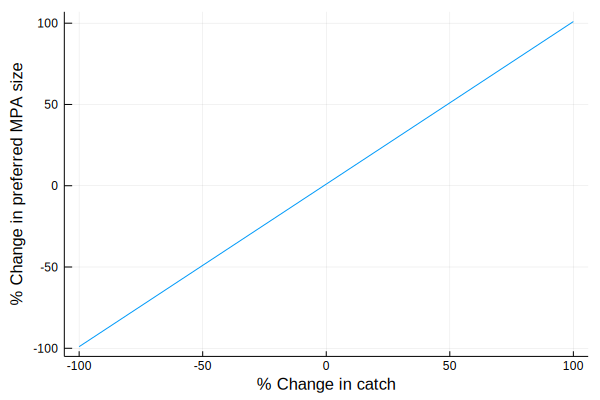

In [3]:
Δα = 1.0
plot(dc -> 1 + Δα * dc, -100, 100, legend=false, xlabel="% Change in catch", ylabel="% Change in preferred MPA size")

The model is defined by the following parameters.  With a little thought it may be possible to make some of these dimensionless, but I've left them concrete for now.

In [32]:
# Fishing ground parameters
K = 1          # carrying capacity, ton fish km^-2
r = 1.5        # Intrinsic growth rate of fish populations
A = 100        # Area of fishing ground, km^2
α0 = 0.0       # Proportion of fishing ground in MPA at start
α1 = 0.3       # Proportion of fishing ground in MPA after 100 timesteps
μ = 0.1        # reserve spillover parameter

# Fisher parameters
a = 10.0       # Search rate, km^2 d^-1
Th = 1.0       # Handling time, boat d (ton fish)^-1
αpref = α1     # The fishers' preferred reserve fraction at beginning
Δα = 10         # How fast the fishers adjust their preferred reserve size
Nfishers = 25  # Number of fishers

25

## Analysis

If all the fishers have identical characteristics, there are three equations governing the population dynamics and fish catch in this system:

\begin{align} 
\Delta_t &= r \left(1 - \frac{N}{A K} \right) \\
S_t &= \mu N_{o} \left(N_r - N_o \frac{\alpha}{1-\alpha} \right) \\
c_t &= N_{fishers} \frac{a n_{o}}{1 + a T_h n_{o}}.
\end{align}

Here, $\Delta_N$ is the change in fish biomass in an area of size $A$.  This is the standard logistic equation for population growth, and gets applied both inside the reserve (with biomass $N_r$ and area $A_r$) and in the open area ($N_o$ and $A_o$).

$S_t$ is the net spillover from the reserve to the open area. It depends on the relative biomasses, the fraction of the ground in the MPA, and the movement parameter $\mu$.

$c_t$, the catch at time $t$, depends on the fishers' search rate $\alpha$ and handling time $T_h$.  It also depends on the density of fish in the open area, defined as $n_o \equiv N_o / A_o$.  This is the Type-II functional response.

If the system is at equilibrium, the population growth in and spillover to the open area must equal the catch at each timestep:

$$
r \left(1 - \frac{N}{A K} \right) + \mu N_{o} \left(N_r - N_o \frac{\alpha}{1-\alpha} \right) = N_{fishers} \frac{a (N_{o}/A_o)}{1 + a T_h (N_{o}/A_o)}.
$$

After some pain-in-the-ass algebra which I don't feel like typing into LaTeX, it can be shown that this equation defines a cubic function in $N_o$, which means we can solve it analytically to determine the equilibrium fish biomasses and catch rates.  I wrote a helper function to do this based on the relevant parameters, using Julia's `Polynomials` package to find the roots.

In [5]:
function biomass_equilibria(A, α, r, K, μ, a, Th, Nfishers)
    Ao = A*(1-α) # open area
    Ar = A*α     # reserve area
    Nr = Ar*K    # reserve fish biomass
    # coefficients for cubic equation
    c0 = μ*Ao*Nr
    c1 = r*Ao - μ*Ar + μ*a*Th*Nr - a*Nfishers
    c2 = -r/K + r*a*Th - μ*a*Th*Ar/Ao
    c3 = -r*a*Th/(Ao*K)
    rts = roots(Poly([c0, c1, c2, c3]))
    # only return the real roots
    return real.(rts[isreal.(rts)])
end

biomass_equilibria (generic function with 1 method)

The following code produces plots of these functions and equilibrium points, using the parameters above, with and without an MPA.

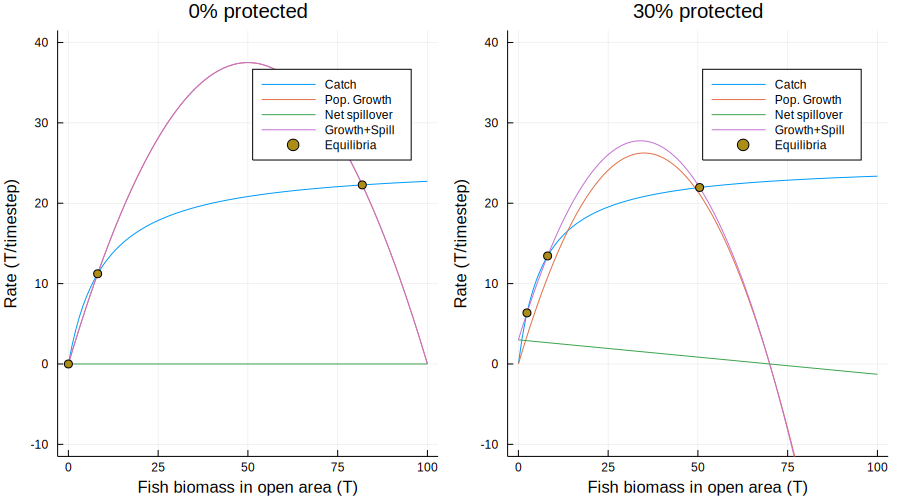

In [6]:
N = range(0, A*K, length=100)

Ao0 = A*(1-α0)
Ar0 = A*α0
fishcatch0 = Nfishers .* m.catch_per_boat.(N/Ao0, a, Th)
fishgrowth0 = N .* m.logistic.(N/Ao0, r, K)
fishspill0 = m.spillover.(Ar0*K, N, μ, α0)
growthspill0 = fishgrowth0 .+ fishspill0
p_before = plot(N, [fishcatch0, fishgrowth0, fishspill0, growthspill0],
    label=["Catch" "Pop. Growth" "Net spillover" "Growth+Spill"],
    xlabel="Fish biomass in open area (T)", ylabel="Rate (T/timestep)", 
    title="$(round(Int, α0 * 100))% protected", ylims=[-10, 40])
eqs0 = biomass_equilibria(A, α0, r, K, μ, a, Th, Nfishers)
scatter!(p_before, eqs0, Nfishers * m.catch_per_boat.(eqs0/(A*(1-α0)), a, Th),
    label="Equilibria")

Ao1 = A*(1-α1)
Ar1 = A*α1
fishcatch1 = Nfishers .* m.catch_per_boat.(N/Ao1, a, Th)
fishgrowth1 = N .* m.logistic.(N/Ao1, r, K)
fishspill1 = m.spillover.(Ar1*K, N, μ, α1)
growthspill1 = fishgrowth1 .+ fishspill1
p_after = plot(N, [fishcatch1, fishgrowth1, fishspill1, growthspill1],
    label=["Catch" "Pop. Growth" "Net spillover" "Growth+Spill"],
    xlabel="Fish biomass in open area (T)", ylabel="Rate (T/timestep)", 
    title="$(round(Int, α1 * 100))% protected", ylims=[-10, 40])
eqs1 = biomass_equilibria(A, α1, r, K, μ, a, Th, Nfishers)
scatter!(p_after, eqs1, Nfishers * m.catch_per_boat.(eqs1/(A*(1-α1)), a, Th,),
    label="Equilibria")
plot(p_before, p_after, size=(900, 500))

You can play around with the parameters and see how they affect the relative shapes of the curves.  A couple of things worth noticing:
* There can be multiple equilibrium points, some stable and some unstable.
* The highest equilibrium catch rate is almost (?) always lower once the MPA is established.

## Simulation

I define a function that sets up and runs a simulation.  After running for 100 timesteps, to let things come to equilibrium, I change the fraction of the fishing ground which is protected.  I also define a convenience plotting function do display the results.

Looking inside `run_simulation`, you can see that for the time being I'm creating all the fishers as identical.  This means the model as run here is currently only technically an ABM, since all the agents are doing exactly the same thing.  That's easy to relax down the road--adding random variation in opinion, search rates, handling times, or even more complicated dynamics like social networks--but for now I've kept it simple.

In [27]:
function run_simulation(params, nsim)
    K, r, A, α0, α1, μ, a, Th, αpref, Δα, Nfishers = params
    # Biomass in reserve and open areas. Both start at carrying capacity
    Nreserve = A * α0 * K
    Nopen = A * (1-α0) * K

    # Instantiate an array of CatchObservingFishers
    fishers = [m.CatchObservingFisher(a, Th, αpref, Δα) for i in 1:Nfishers]
    # Instantiate a FishingGround
    ground = m.FishingGround(K, r, A, α0, μ, Nreserve, Nopen)

    NNres = zeros(nsim)
    NNopen = zeros(nsim)
    spill = zeros(nsim)
    landings = zeros(nsim)
    αα_avg = fill(α0, nsim)

    for t in 1:nsim
        NNres[t] = ground.Nreserve
        NNopen[t] = ground.Nopen
        spill[t] = m.spillover(ground.Nreserve, ground.Nopen, ground.μ, ground.α)
        landings[t] = m.harvest!(ground, fishers)
        m.update_opinion!.(fishers)
        if t > 100
            αα_avg[t] = m.α_consensus(fishers)
            m.set_protected!(ground, αα_avg[t])
        end
        if t == 100
            m.set_protected!(ground, α1)
            αα_avg[t] = α1
        end
    end
    return (NNopen, NNres, spill, landings, αα_avg)
end

function plot_results(NNopen, NNres, spill, landings, αα_avg, burnin=1)
    p1 = plot(NNopen[burnin:end], label="Open biomass", ylabel="Biomass (T)");
    plot!(p1, NNres[burnin:end], label="MPA biomass");
    plot!(p1, landings[burnin:end], label="Landings");
    plot!(p1, spill[burnin:end], label="Spillover")
    p2 = plot(landings[burnin:end], label="Landings", ylabel="Biomass (T)", linecolor=:green);
    p3 = plot(αα_avg[burnin:end], label="MPA fraction", xlabel="Timestep",
        ylabel="Fraction", linecolor=:black);
    p = plot(p1, p2, p3, layout=(3,1))
    return p
end


plot_results (generic function with 2 methods)

Packing all the parameters into a named tuple and running the simulation:

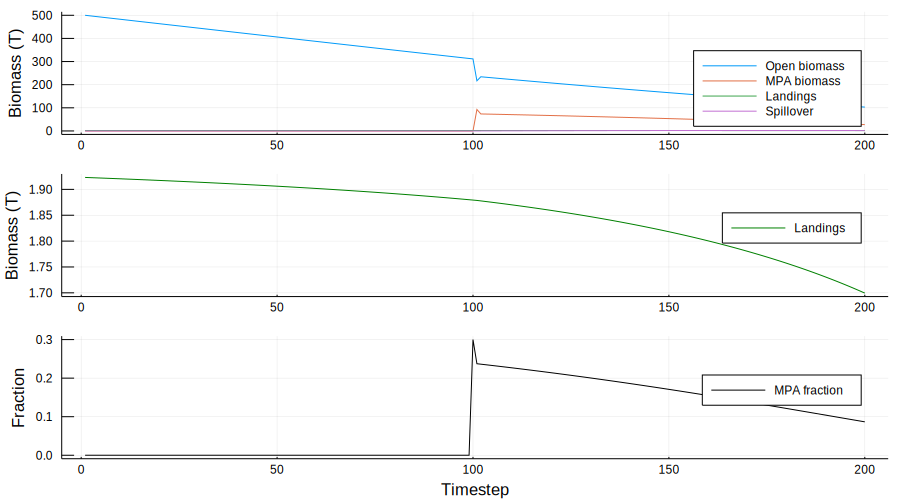

In [55]:
params1 = (K=5, r=2, A=A, α0=α0, α1=α1, μ=μ,
    a=1, Th=5, αpref=αpref, Δα=Δα, Nfishers=10)
nsim = 200
res1 = run_simulation(params1, nsim) #No, Nr, spillover, landings, α_avg
gr(size=(900, 500)) # set plot size
p1 = plot_results(res1...)

In this simulation, the fishers start out preferring a 30% MPA size (`αpref=α0=0.3`), the same as the "policy" that is imposed at `t=100`. When the reserve is implemented, though, the available fishing area drops, along with the fishers' total landings.  In response, they decrease their preferred reserve size until the equilibrium is re-acheived.

Let's do another simulation, making them more skeptical: this time, they prefer a 5% reserve (`αpref=0.05`).  As before, the 30% reserve is implemented halfway through the simulation, and the fishers adjust the size at each timestep after that.

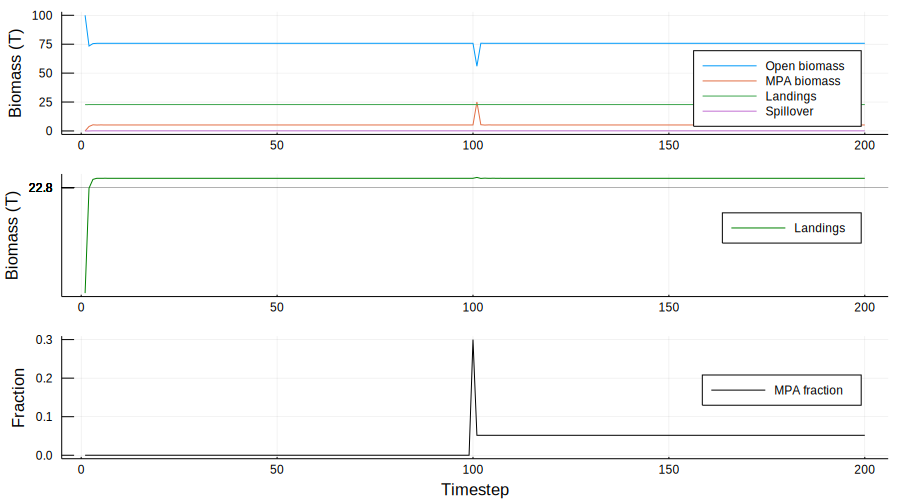

In [19]:
params2 = (K=K, r=r, A=A, α0=α0, α1=α1, μ=μ, 
    a=a, Th=Th, αpref=0.05, Δα=Δα, Nfishers=Nfishers)
res2 = run_simulation(params2, nsim)
plot_results(res2...)

In [182]:
last(res2[5])

0.05174545935553504

Here, the fishers quickly vote down the reserve size from 30% to 5.2%, just a hair over their initial preference. 